# Overfit-Generalization-Underfit

In the previous notebook, we presented the general cross-validation framework and how it helps us quantify the training and testing errors as well as their fluctuations.

In this notebook, we will put these two errors into perspective and show how they can help us know if our model generalizes, overfits, or underfits.

Let's first import pandas and load the data.

In [2]:
import pandas as pd
# Disable jedi autocompleter
%config Completer.use_jedi = False
from sklearn.datasets import fetch_california_housing

In [3]:
housing = fetch_california_housing(as_frame=True)
data = housing.data
target = housing.target*100

In [4]:
from sklearn.tree import DecisionTreeRegressor

In [5]:
regressor = DecisionTreeRegressor()

## Overfitting vs. Underfitting

To better understand the generalization performance of our model and maybe find insights on how to improve it, we will compare the testing error with the training error. Thus, we need to compute the error on the training set, which is possible using the `cross_validate` function.

In [8]:
from sklearn.model_selection import cross_validate, ShuffleSplit

In [9]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

The cross-validation used the negative mean absolute error.  We transform the negative absolute error into a positive mean absolute error.

In [10]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[["train_score", "test_score"]]

By plotting the distribution of the training and testing errors, we get information about whether our model is over-fitting, under-fitting or both

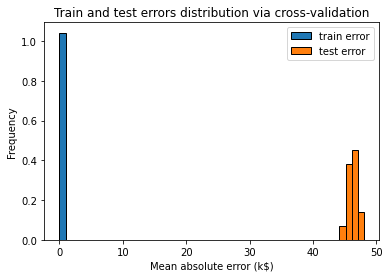

In [12]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
plt.title("Train and test errors distribution via cross-validation");

Here, we observe a small training error (actually zero), meaning the model is **not under-fitting**: it is flexible enough to capture any variations present in the training set.

However the significantly larger testing error tells us that the model is over-fitting: The model has memorized many variations of the training set that could be considered "noisy" because they do not generalize to help us make good prediction on the test set.